In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, Model, losses
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

2025-06-12 17:07:03.394398: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 17:07:03.395365: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 17:07:03.399859: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-12 17:07:03.405641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749748023.414217      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749748023.41

# Carga de Datos

In [2]:
# Dataset cargado como antes
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    '../data/raw/sports_balls/train',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32
)

Found 7328 files belonging to 15 classes.


2025-06-12 17:07:26.992129: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    '../data/raw/sports_balls/test',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32
)

Found 1841 files belonging to 15 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds = raw_test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

In [5]:
class_names = raw_train_ds.class_names

In [6]:
print(class_names)

['american_football', 'baseball', 'basketball', 'billiard_ball', 'bowling_ball', 'cricket_ball', 'football', 'golf_ball', 'hockey_ball', 'hockey_puck', 'rugby_ball', 'shuttlecock', 'table_tennis_ball', 'tennis_ball', 'volleyball']


# Modelo Neuronal

In [7]:
# Modelo base
#base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#base_model.trainable = False

In [8]:
class DeepIB(Model):
    def __init__(self, z_dim, sampling=1, beta=1.0):
        super(DeepIB, self).__init__()
        self.sampling = sampling
        self.beta = beta

        self.base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        self.base_model.trainable = False

        # Encoder
        self.encoder_x = tf.keras.Sequential([
            tf.keras.Input(shape=(224, 224, 3)),
            self.base_model,
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.3)
        ])
        self.encoder_mu = layers.Dense(z_dim)
        self.encoder_logvar = layers.Dense(z_dim)

        # Decoder
        self.decode_z = layers.Dense(len(class_names))  # Para clasificación en las clases

    def encode(self, x):
        x = self.encoder_x(x)
        mu = self.encoder_mu(x)
        logvar = self.encoder_logvar(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        eps_shape = tf.concat([tf.shape(mu), [self.sampling]], axis=0)
        eps = tf.random.normal(eps_shape)
        sigma = tf.exp(0.5 * logvar)
        mu = tf.expand_dims(mu, -1)
        sigma = tf.expand_dims(sigma, -1)
        z = mu + sigma * eps
        z = tf.transpose(z, perm=[0, 2, 1])  # [batch, samples, z_dim]
        return z

    def call(self, x, training=False):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        y_pred = self.decode_z(z)  # [batch, samples, 10]
        return y_pred, mu, logvar

    def compute_loss(self, x, y_true):
        y_pred, mu, logvar = self.call(x, training=True)
        y_pred = tf.reduce_mean(y_pred, axis=1)  # Promedio sobre muestras
        ce_loss = losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
        # KL divergence
        var = tf.exp(logvar)
        kl = -0.5 * tf.reduce_sum(1 + tf.math.log(var) - tf.square(mu) - var, axis=1)
        _total_loss = tf.reduce_mean(ce_loss + self.beta * kl)
        # Accuracy
        _acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_pred, axis=1), tf.cast(y_true, tf.int64)), tf.float32))
        return _total_loss, _acc

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            loss, acc = self.compute_loss(x, y)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss, "accuracy": acc}

    def test_step(self, data):
        x, y = data
        loss, acc = self.compute_loss(x, y)
        return {"loss": loss, "accuracy": acc}

In [9]:
# Instanciar y entrenar el modelo
model = DeepIB(z_dim=2, sampling=1, beta=1e-4)
model.compile(optimizer=tf.keras.optimizers.Adam())

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [10]:
dummy_input = tf.keras.Input(shape=(224, 224, 3))
output = model(dummy_input)
model.summary()

Model: "deep_ib"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 512)            │    24,622,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 15)          │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,624,177 (93.93 MB)

 Trainable params: 1,055,281 (4.03 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

# Entrenamiento

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 184s 783ms/step - accuracy: 0.3827 - loss: 1.8443 - val_accuracy: 0.4118 - val_loss: 2.1156
Epoch 2/10
 73/229 ━━━━━━━━━━━━━━━━━━━━ 1:40 647ms/step - accuracy: 0.5210 - loss: 1.4689

# Visualización de Resultados

In [ ]:
import matplotlib.pyplot as plt

2025-06-12 17:01:11.331849: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


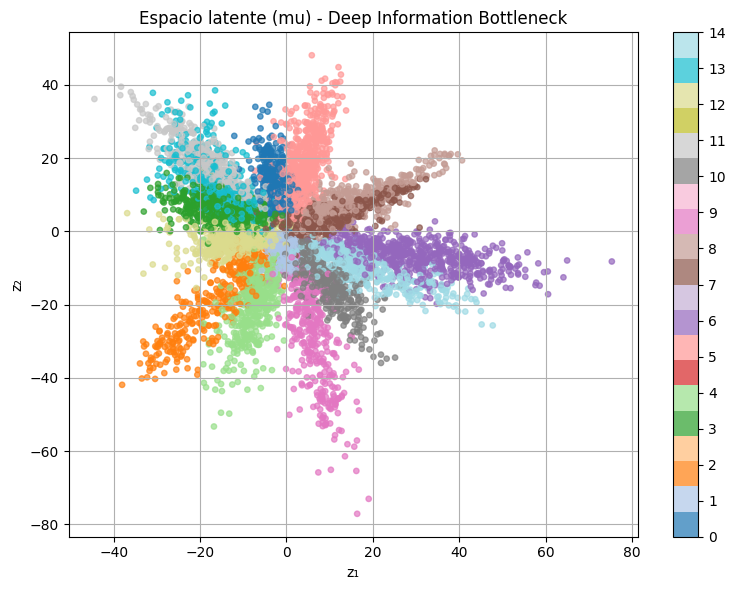

In [19]:
# Listas para almacenar las representaciones latentes y las etiquetas
latents = []
labels = []

# Desactiva el entrenamiento para evitar muestreo aleatorio (usa solo mu)
for x_batch, y_batch in test_ds:
    mu, _ = model.encode(x_batch)
    latents.append(mu.numpy())
    labels.append(y_batch.numpy())

# Concatenar todo en arrays
latents = np.concatenate(latents, axis=0)  # (N, 2)
labels = np.concatenate(labels, axis=0)    # (N,)

In [ ]:
# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab20', alpha=0.7, s=15)
plt.colorbar(scatter, ticks=range(len(np.unique(labels))))
plt.xlabel("z₁")
plt.ylabel("z₂")
plt.title("Espacio latente (mu) - Deep Information Bottleneck")
plt.grid(True)
plt.tight_layout()
plt.show()